# Trajectory Generator

In [1]:
import numpy as np
import matplotlib.pyplot as plt


### Define the simulation space

In [2]:
class SimulationSpace:
    def __init__(self, size=(100, 100), destination_points=None):
        self.width, self.height = size
        self.destination_points = destination_points if destination_points else []
        self.starting_points = []  # List of StartingPoint objects
        self.agents = []  # List of Agent objects
        self._id_counter = 0  # Internal counter for assigning agent IDs

    def add_destination_point(self, destination_point):
        """Add a DestinationPoint object."""
        self.destination_points.append(destination_point)

    def add_starting_point(self, starting_point):
        """Add a StartingPoint object to the space."""
        if not self.destination_points:
            raise ValueError("Define destination points before adding starting points.")
        self.starting_points.append(starting_point)

    def add_agent(self, agent):
        """Add an Agent object to the space."""
        agent.id = self._id_counter  # Assign a unique ID
        self._id_counter += 1  # Increment the ID counter
        self.agents.append(agent)

    def clamp_position(self, position):
        """
        Clamp a position to ensure it lies within the simulation space.
        
        Parameters:
            position (tuple or ndarray): The position to check and adjust.

        Returns:
            ndarray: The clamped position.
        """
        x, y = position
        clamped_x = min(max(x, 0), self.width)
        clamped_y = min(max(y, 0), self.height)
        return np.array([clamped_x, clamped_y])

    def visualize_space(self):
        """Visualize the space, including starting points, destination points, and agents."""
        plt.figure(figsize=(8, 8))
        plt.xlim(0, self.width)
        plt.ylim(0, self.height)
        plt.gca().set_aspect('equal', adjustable='box')

        # Plot starting points
        if self.starting_points:
            starting_points_coords = np.array([[sp.x, sp.y] for sp in self.starting_points])
            plt.scatter(starting_points_coords[:, 0], starting_points_coords[:, 1], 
                        c='blue', label='Starting Points')

        # Plot destination points
        if self.destination_points:
            destination_coords = np.array([[dp.x, dp.y] for dp in self.destination_points])
            plt.scatter(destination_coords[:, 0], destination_coords[:, 1], 
                        c='red', label='Destination Points')

        # Plot agent starting positions
        if self.agents:
            agent_start_positions = np.array([agent.position for agent in self.agents])
            plt.scatter(agent_start_positions[:, 0], agent_start_positions[:, 1], 
                        c='green', label='Agent Starting Positions')

        plt.title("Simulation Space")
        plt.xlabel("X")
        plt.ylabel("Y")
        plt.legend()
        plt.grid()
        plt.show()
 

class StartingPoint:
    def __init__(self, x, y, simulation_space, position_std=5.0, destination_probs=None):
        """
        Initialize a StartingPoint.

        Parameters:
            x, y (float): Coordinates of the starting point.
            simulation_space (SimulationSpace): Parent simulation space.
            position_std (float): Standard deviation for the Gaussian position distribution.
            destination_probs (list): Probability distribution over destination points.
        """
        self.x = x
        self.y = y
        self.simulation_space = simulation_space
        self.position_std = position_std

        # Validate destination probabilities
        if destination_probs:
            if len(destination_probs) != len(simulation_space.destination_points):
                raise ValueError("Number of probabilities must match number of destination points.")
            if not np.isclose(sum(destination_probs), 1.0):
                raise ValueError("Probabilities must sum to 1.")
        self.destination_probs = destination_probs

    def sample_position(self):
        """
        Sample a random starting position from a Gaussian centered at (x, y).
        Returns:
            (float, float): Sampled position.
        """
        return np.random.normal(loc=(self.x, self.y), scale=self.position_std, size=2)

    def sample_destination(self):
        """
        Sample a destination point based on the defined probabilities.
        Returns:
            (float, float): Destination point.
        """
        if self.destination_probs is None:
            raise ValueError("Destination probabilities not defined for this starting point.")
        destination_index = np.random.choice(len(self.simulation_space.destination_points), p=self.destination_probs)
        return self.simulation_space.destination_points[destination_index]

class DestinationPoint:
    def __init__(self, x, y, stop_mean=1.0, stop_std=0.2):
        """
        Initialize a destination point.

        Parameters:
            x, y (float): Coordinates of the destination point.
            stop_mean (float): Mean of the Gaussian distribution for stopping point.
            stop_std (float): Standard deviation of the Gaussian distribution for stopping point.
        """
        self.x = x
        self.y = y
        self.stop_mean = stop_mean
        self.stop_std = stop_std

    def sample_stopping_point(self):
        """
        Sample a stopping point near the destination.

        Returns:
            tuple: Sampled stopping point coordinates (x, y).
        """
        stop_x = np.random.normal(loc=self.x, scale=self.stop_std)
        stop_y = np.random.normal(loc=self.y, scale=self.stop_std)
        return stop_x, stop_y

In [3]:
class Agent:
    def __init__(self, simulation_space):
        self.id = None  # Unique ID assigned during addition to the simulation space
        self.simulation_space = simulation_space  # Reference to the simulation space
        self.starting_point = None  # Starting point object
        self.position = None  # Current position of the agent
        self.destination = None  # Destination point object
        self.stopping_point = None  # Final stopping point sampled near the destination
        self.trajectory = []  # List of positions forming the trajectory

    def initialize_agent(self):
        """Initialize the agent's starting position and destination."""
        # Select a starting point and sample the agent's initial position
        self.starting_point = np.random.choice(self.simulation_space.starting_points)
        self.position = self.simulation_space.clamp_position(self.starting_point.sample_position())

        # Sample a destination point and draw a stopping point near it
        self.destination = self.starting_point.sample_destination()
        self.stopping_point = self.destination.sample_stopping_point()

        # Add the starting position to the trajectory
        self.trajectory.append(tuple(self.position))

    def generate_next_step(self, step_size_params=(1.0, 0.2), noise_params=(0.0, 0.1)):
        """
        Generate the next position in the trajectory.

        Parameters:
            step_size_params (tuple): Mean and std-dev for step size sampling (Gaussian).
            noise_params (tuple): Mean and std-dev for noise sampling (Gaussian).

        Returns:
            tuple: The next position (x, y) as a tuple.
        """
        if self.position is None or self.stopping_point is None:
            raise ValueError("Agent must be initialized before generating steps.")

        # Extract step size and noise parameters
        step_size_mean, step_size_std = step_size_params
        noise_mean, noise_std = noise_params

        # Compute the direction vector toward the stopping point
        direction = np.array(self.stopping_point) - self.position
        distance_to_stop = np.linalg.norm(direction)
        unit_direction = direction / distance_to_stop

        # Sample step size and noise
        step_size = np.random.normal(loc=step_size_mean, scale=step_size_std)
        noise = np.random.normal(loc=noise_mean, scale=noise_std, size=2)

        # Compute the next position
        next_position = self.position + step_size * unit_direction + noise
        self.position = self.simulation_space.clamp_position(next_position)
        self.trajectory.append(tuple(self.position))

        return tuple(self.position)

    def has_reached_destination(self):
        """
        Check if the agent has reached its stopping point.

        Returns:
            bool: True if the agent is within a small distance of the stopping point.
        """
        if self.position is None or self.stopping_point is None:
            raise ValueError("Agent must be initialized before checking the stop condition.")

        # Compute the distance to the stopping point
        distance_to_stop = np.linalg.norm(np.array(self.stopping_point) - self.position)
        return distance_to_stop <= 1.0  # Threshold for "close enough"

In [4]:
class Simulation:
    def __init__(self, simulation_space, agents):
        """
        Initialize the Simulation.

        Parameters:
            simulation_space (SimulationSpace): The simulation space containing starting and destination points.
            agents (list): List of Agent objects participating in the simulation.
        """
        self.simulation_space = simulation_space
        self.agents = agents
        self.trajectories = {agent.id: [] for agent in agents}  # Use agent IDs as keys

    def run_simulation(self):
        """
        Run the simulation until all agents reach their respective destinations.
        """
        active_agents = set(self.agents)  # Keep track of agents still moving

        while active_agents:
            for agent in list(active_agents):
                if not agent.has_reached_destination():
                    agent.generate_next_step()
                    self.trajectories[agent.id] = agent.trajectory  # Update trajectory using agent ID as key
                else:
                    active_agents.remove(agent)

        print("Simulation complete! All agents have reached their destinations.")

    def visualize_trajectories(self):
        """
        Visualize the trajectories of all agents along with starting and destination points.
        """
        plt.figure(figsize=(8, 8))
        plt.xlim(0, self.simulation_space.width)
        plt.ylim(0, self.simulation_space.height)
        plt.gca().set_aspect('equal', adjustable='box')

        # Plot starting points
        if self.simulation_space.starting_points:
            starting_points_coords = np.array([[sp.x, sp.y] for sp in self.simulation_space.starting_points])
            plt.scatter(starting_points_coords[:, 0], starting_points_coords[:, 1], 
                        c='orange', zorder=4, label='Starting Points')

        # Plot destination points
        if self.simulation_space.destination_points:
            destination_coords = np.array([[dp.x, dp.y] for dp in self.simulation_space.destination_points])
            plt.scatter(destination_coords[:, 0], destination_coords[:, 1], 
                        c='red', zorder=3, label='Destination Points')

        # Plot agent starting positions
        agent_start_positions = np.array([agent.trajectory[0] for agent in self.agents])
        plt.scatter(agent_start_positions[:, 0], agent_start_positions[:, 1], 
                    c='green', marker='o', label='Agent Starting Positions')

        # Plot agent trajectories
        for agent_id, trajectory in self.trajectories.items():
            trajectory = np.array(trajectory)
            plt.plot(trajectory[:, 0], trajectory[:, 1], color='green', linewidth=1)

        plt.title("Simulation Trajectories")
        plt.xlabel("X")
        plt.ylabel("Y")
        plt.legend()
        plt.grid()
        plt.show()

Simulation complete! All agents have reached their destinations.


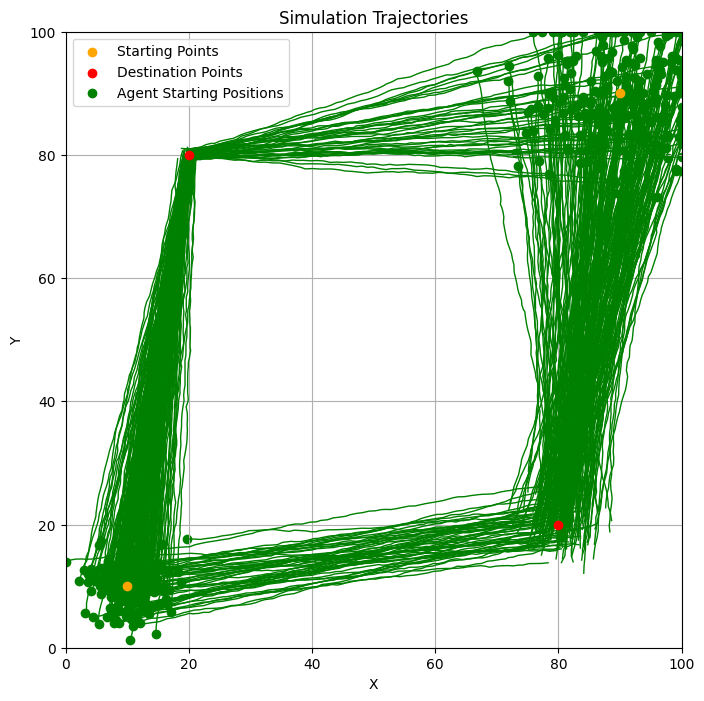

In [5]:
# Define destination points with the new stopping point logic
destination_1 = DestinationPoint(x=20, y=80, stop_mean=2.0, stop_std=0.5)
destination_2 = DestinationPoint(x=80, y=20, stop_mean=5.0, stop_std=3.0)

# Initialize the simulation space
space = SimulationSpace(size=(100, 100), destination_points=[destination_1, destination_2])

# Add starting points
starting_point_1 = StartingPoint(x=10, y=10, simulation_space=space, position_std=3.0, destination_probs=[0.8, 0.2])
starting_point_2 = StartingPoint(x=90, y=90, simulation_space=space, position_std=8.0, destination_probs=[0.2, 0.8])
space.add_starting_point(starting_point_1)
space.add_starting_point(starting_point_2)

# Create agents
agents = []
for _ in range(500):  # Generate agents
    agent = Agent(simulation_space=space)
    agent.initialize_agent()
    agents.append(agent)

# Add agents to the simulation space
for agent in agents:
    space.add_agent(agent)

# Run the simulation
simulation = Simulation(simulation_space=space, agents=agents)
simulation.run_simulation()

# Visualize the trajectories
simulation.visualize_trajectories()

## HMM for Goal Based Clustering

In [6]:
trajectories = simulation.trajectories

In [7]:
# trajectories: Original trajectory dictionary {id: [(x1, y1), (x2, y2), ...]}
max_len = max(len(traj) for traj in trajectories.values())  # Find max trajectory length
dataset = TrajectoryDataset(trajectories, max_len=max_len)  # Prepare data

# Extract interpolated trajectories
data = np.array([traj for traj in dataset.inputs])  # Shape: (num_trajectories, max_len-1, 2)
num_trajectories, target_length, dim = data.shape
print(f"Trajectory Data Shape: {data.shape}")

NameError: name 'TrajectoryDataset' is not defined

In [8]:
# Step 1: Compute likelihood function
def compute_likelihood(trajectory, motion_means, beta, sigma):
    """
    Compute the likelihood of a trajectory under a motion pattern.
    Parameters:
        trajectory (np.ndarray): The interpolated trajectory.
        motion_means (np.ndarray): Means for a motion pattern.
        beta (int): Range for each Gaussian component.
        sigma (float): Standard deviation of the Gaussian components.
    """
    T = len(trajectory)
    likelihood = 1.0
    for t in range(T):
        k = min(t // beta, K - 1)  # Ensure we don't exceed the Gaussian components
        gaussian = multivariate_normal(mean=motion_means[k], cov=np.eye(2) * sigma**2)
        likelihood *= gaussian.pdf(trajectory[t])
    return likelihood

def compute_log_likelihood(trajectory, motion_means, beta, sigma):
    """Compute the log-likelihood of a trajectory under a motion pattern."""
    T = len(trajectory)
    log_likelihood = 0.0  # Use log-space to avoid underflow

    for t in range(T):
        k = min(t // beta, len(motion_means) - 1)  # Ensure we don't exceed Gaussian components
        gaussian = multivariate_normal(mean=motion_means[k], cov=np.eye(2) * sigma**2)
        
        # Add log-probability instead of multiplying raw probabilities
        log_likelihood += np.log(gaussian.pdf(trajectory[t]) + 1e-10)  # Avoid log(0)

    return log_likelihood


# Step 2: Expectation Step
def expectation_step(data, means, beta, sigma):
    """E-Step: Compute responsibilities c_im."""
    num_trajectories = len(data)
    M = len(means)
    responsibilities = np.zeros((num_trajectories, M))

    for i, trajectory in enumerate(data):
        for m in range(M):
            responsibilities[i, m] = np.exp(compute_likelihood(trajectory, means[m], beta, sigma))

        responsibilities[i] /= (np.sum(responsibilities[i]) + 1e-10)  # Normalize to avoid NaN

    print(responsibilities)
    return responsibilities


# Step 3: Maximization Step
def maximization_step(data, responsibilities, beta):
    """M-Step: Update the Gaussian means."""
    M, K, dim = means.shape
    new_means = np.zeros_like(means)

    for m in range(M):
        for k in range(K):
            start, end = k * beta, min((k + 1) * beta, target_length)  # Cap range at target_length
            weighted_sum = np.zeros(dim)
            total_weight = 0.0

            for i, trajectory in enumerate(data):
                for t in range(start, end):
                    weighted_sum += responsibilities[i, m] * trajectory[t]
                    total_weight += responsibilities[i, m]

            new_means[m, k] = weighted_sum / (total_weight + 1e-10)  # Avoid division by zero

    return new_means

In [580]:
# Step 4: EM Algorithm
M = 2  # Number of motion patterns (goals)
K = 5  # Number of Gaussian components per motion pattern
sigma = 5.0  # Fixed standard deviation for Gaussians


# Initialize motion pattern means using K-means on trajectory endpoints
endpoints = np.array([traj[-1] for traj in data])  # Use last point of each trajectory
kmeans = KMeans(n_clusters=M, random_state=42).fit(endpoints)

# Initialize means: distribute K Gaussians along the endpoint for each motion pattern
means = np.array([np.linspace(kmeans.cluster_centers_[m], kmeans.cluster_centers_[m], K) 
                  for m in range(M)])
means += np.random.normal(scale=0.5, size=means.shape)  # Add small noise to break symmetry

beta = target_length // K  # Range for each Gaussian
max_iterations = 20
tolerance = 1e-4

print("Starting EM Algorithm...")
for iteration in range(max_iterations):
    # E-Step
    responsibilities = expectation_step(data, means, beta, sigma)

    # M-Step
    new_means = maximization_step(data, responsibilities, beta)

    # Check convergence
    diff = np.linalg.norm(new_means - means)
    print(f"Iteration {iteration + 1}, Change in Means: {diff:.4f}")
    means = new_means

    if diff < tolerance:
        print("Convergence reached.")
        break

print("EM Algorithm Complete.")
print("Final Motion Pattern Means:")
print(means)


/Users/nigeldoering/miniconda3/envs/community_detection/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Starting EM Algorithm...
Iteration 1, Change in Means: 131.4690
Iteration 2, Change in Means: 0.0000
Convergence reached.
EM Algorithm Complete.
Final Motion Pattern Means:
[[[47.73518749 47.40102885]
  [48.16479005 48.04272192]
  [48.61237548 48.66217879]
  [49.06496779 49.3251891 ]
  [49.54666061 49.9482509 ]]

 [[47.73518749 47.40102885]
  [48.16479005 48.04272192]
  [48.61237548 48.66217879]
  [49.06496779 49.3251891 ]
  [49.54666061 49.9482509 ]]]


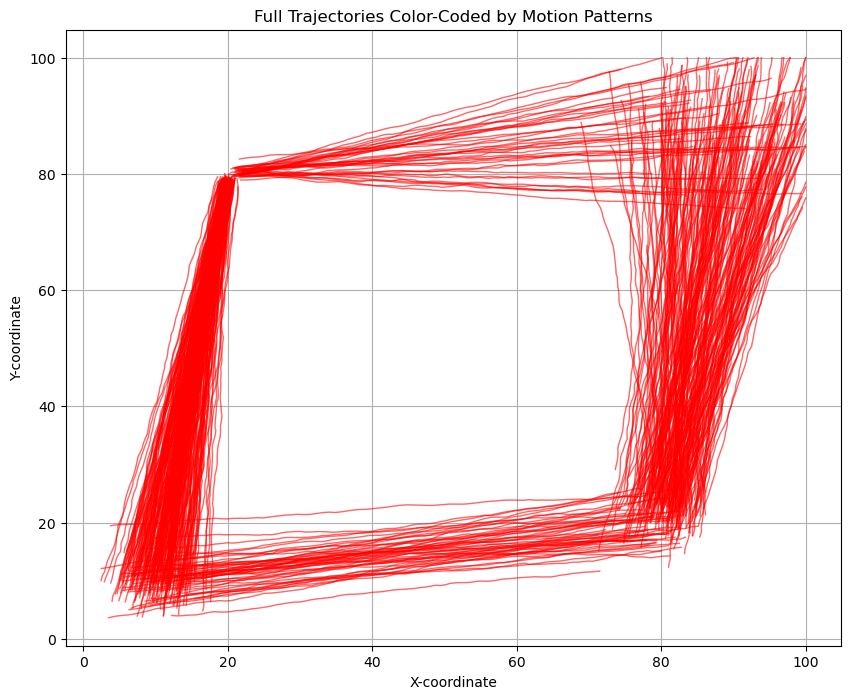

In [581]:

# Step 2: Assign each trajectory to the motion pattern with the highest responsibility
trajectory_assignments = np.argmax(responsibilities, axis=1)  # Shape: (num_trajectories,)

# Step 3: Define colors for the two motion patterns
colors = ['red', 'blue']  # Motion pattern 0: red, Motion pattern 1: blue

# Step 4: Plot all trajectories color-coded by their motion pattern assignment
plt.figure(figsize=(10, 8))
for i, trajectory in enumerate(trajectory_data):
    assignment = trajectory_assignments[i]
    plt.plot(trajectory[:, 0], trajectory[:, 1], color=colors[assignment], alpha=0.6, linewidth=1)

plt.title("Full Trajectories Color-Coded by Motion Patterns")
plt.xlabel("X-coordinate")
plt.ylabel("Y-coordinate")
plt.grid(True)
plt.show()

## HMM for Trajectory Modeling Under the Influence of Goals

In [322]:
trajectories = simulation.trajectories

In [300]:
def normalize_trajectories(trajectories):
    all_points = np.concatenate([np.array(t) for t in trajectories.values()])
    min_vals = all_points.min(axis=0)
    max_vals = all_points.max(axis=0)
    range_vals = max_vals - min_vals

    normalized = {}
    for traj_id, trajectory in trajectories.items():
        normalized[traj_id] = [(np.array(point) - min_vals) / range_vals for point in trajectory]
    return normalized, min_vals, range_vals

In [301]:
import numpy as np
from scipy.stats import multivariate_normal



In [314]:
class HMM:
    def __init__(self, num_states, num_goals, trajectories, alpha=1.0):
        self.num_states = num_states
        self.num_goals = num_goals
        self.trajectories = trajectories
        self.alpha = alpha

        # Initialize states randomly in a 2D space
        self.states = np.random.rand(num_states, 2) * 100  # Assume space is 100x100
        print(f"Initialized states: {self.states}")

        # Initialize goal positions randomly in the 2D space
        self.goals = np.random.rand(num_goals, 2) * 100
        print(f"Initialized goals: {self.goals}")

        # Initialize transition probabilities
        self.transitions = np.array([self._calculate_transition_matrix(goal) for goal in self.goals])
        print(f"Initialized transition matrices for {num_goals} goals.")

        # Initialize emission parameters
        self.emission_means = np.array([np.copy(self.states) for _ in range(self.num_goals)])
        self.emission_covariances = np.array([
            [np.eye(2) * 5 for _ in range(self.num_states)]
            for _ in range(self.num_goals)
        ])
        print(f"Initialized emission means and covariances.")

        # Initialize initial state probabilities
        self.initial_probs = np.full(num_states, 1 / num_states)
        print(f"Initialized initial state probabilities: {self.initial_probs}")

    def _calculate_transition_matrix(self, goal):
        """
        Calculate transition probabilities for a specific goal.
        """
        num_states = self.num_states
        transition_matrix = np.zeros((num_states, num_states))
        for i in range(num_states):
            for j in range(num_states):
                distance_to_goal = np.linalg.norm(self.states[j] - goal)
                transition_matrix[i, j] = np.exp(-self.alpha * distance_to_goal)
            # Normalize each row
            transition_matrix[i, :] /= np.sum(transition_matrix[i, :])
        return transition_matrix
    
    def e_step(self):
        """
        Perform the E-step: compute responsibilities.
        Returns:
            responsibilities: A dictionary mapping trajectory IDs to soft assignments.
        """
        print("Starting E-step...")
        responsibilities = {traj_id: np.zeros(self.num_goals) for traj_id in self.trajectories}
    
        for traj_id, trajectory in self.trajectories.items():
            trajectory = np.array(trajectory)  # Convert to numpy array
            for k, goal in enumerate(self.goals):
                # Compute the likelihood of the trajectory under goal k
                likelihood = 1.0
                for t, point in enumerate(trajectory):
                    emission_probs = [
                        multivariate_normal.pdf(point, mean=self.emission_means[k][s], cov=self.emission_covariances[k][s])
                        for s in range(self.num_states)
                    ]
                    likelihood *= sum(emission_probs) * self.initial_probs[t % self.num_states]
                responsibilities[traj_id][k] = likelihood
    
            # Normalize responsibilities for the trajectory
            total_responsibility = np.sum(responsibilities[traj_id])
            if total_responsibility == 0:
                # Assign uniform responsibilities to avoid NaN
                responsibilities[traj_id] = np.ones(self.num_goals) / self.num_goals
            else:
                responsibilities[traj_id] /= total_responsibility
    
        print("E-step complete.")
        return responsibilities

    def m_step(self, responsibilities):
        """
        Perform the M-step: update goals and HMM parameters.
        """
        print("Starting M-step...")

        # Update goals
        for k in range(self.num_goals):
            weighted_sum = np.zeros(2)
            total_weight = 0
            for traj_id, trajectory in self.trajectories.items():
                weight = responsibilities[traj_id][k]
                endpoint = np.array(trajectory[-1])
                weighted_sum += weight * endpoint
                total_weight += weight
            if total_weight > 0:
                self.goals[k] = weighted_sum / total_weight

        print(f"Updated goals: {self.goals}")

        # Update transition probabilities
        self.transitions = np.array([self._calculate_transition_matrix(goal) for goal in self.goals])
        print("Updated transition matrices.")

        # Update emission parameters
        for k in range(self.num_goals):
            for s in range(self.num_states):
                # Update mean for state s under goal k
                weighted_sum = np.zeros(2)
                total_weight = 0
                for traj_id, trajectory in self.trajectories.items():
                    weight = responsibilities[traj_id][k]
                    for t, point in enumerate(trajectory):
                        weighted_sum += weight * np.array(point)
                        total_weight += weight
                if total_weight > 0:
                    self.emission_means[k][s] = weighted_sum / total_weight

                # Update covariance for state s under goal k
                covariance_sum = np.zeros((2, 2))
                for traj_id, trajectory in self.trajectories.items():
                    weight = responsibilities[traj_id][k]
                    for t, point in enumerate(trajectory):
                        diff = np.array(point) - self.emission_means[k][s]
                        covariance_sum += weight * np.outer(diff, diff)
                if total_weight > 0:
                    self.emission_covariances[k][s] = covariance_sum / total_weight

            print(f"Updated emission parameters for Goal {k}.")

        print("M-step complete.")

    def train(self, max_iterations=100, tolerance=1e-4):
        prev_likelihood = -np.inf
        for iteration in range(max_iterations):
            print(f"Starting iteration {iteration + 1}...")

            # E-step
            responsibilities = self.e_step()

            # M-step
            self.m_step(responsibilities)

            # Compute likelihood
            likelihood = 0.0
            for traj_id, trajectory in self.trajectories.items():
                for k in range(self.num_goals):
                    likelihood += responsibilities[traj_id][k] * np.log(responsibilities[traj_id][k] + 1e-10)  # Avoid log(0)

            print(f"Iteration {iteration + 1}, Log-Likelihood: {likelihood}")
            if np.abs(likelihood - prev_likelihood) < tolerance:
                print("Convergence reached!")
                break
            prev_likelihood = likelihood

        print("Training complete.")

In [315]:
normalized_trajectories, min_vals, range_vals = normalize_trajectories(trajectories)
hmm = HMM(num_states=4, num_goals=2, trajectories=normalized_trajectories, alpha=1.0)


Initialized states: [[72.36509301  2.21512414]
 [44.25689746 95.05492778]
 [49.97422159 90.40772403]
 [ 4.22006895 28.95657171]]
Initialized goals: [[42.62110443 20.97271055]
 [21.02964458 53.25631603]]
Initialized transition matrices for 2 goals.
Initialized emission means and covariances.
Initialized initial state probabilities: [0.25 0.25 0.25 0.25]


In [316]:
# Train the HMM
hmm.train(max_iterations=100, tolerance=1e-4)

de_normalized_goals = hmm.goals * range_vals + min_vals
print("De-normalized goals:", de_normalized_goals)

Starting iteration 1...
Starting E-step...
E-step complete.
Starting M-step...
Updated goals: [[0.45072242 0.53373655]
 [0.45072242 0.53373655]]
Updated transition matrices.
Updated emission parameters for Goal 0.
Updated emission parameters for Goal 1.
M-step complete.
Iteration 1, Log-Likelihood: -346.57359017997334
Starting iteration 2...
Starting E-step...
E-step complete.
Starting M-step...
Updated goals: [[0.45072242 0.53373655]
 [0.45072242 0.53373655]]
Updated transition matrices.
Updated emission parameters for Goal 0.
Updated emission parameters for Goal 1.
M-step complete.
Iteration 2, Log-Likelihood: -346.57359017997334
Convergence reached!
Training complete.
De-normalized goals: [[46.6186963  53.37365511]
 [46.6186963  53.37365511]]


## VAE Modeling  
The main idea is to construct and train a simple VAE which will learn to predict the next sequence in a trajectory. The embedding layer will hopefully learn useful features in the latent space such as the destination goal of an agent. We will then apply clustering algorithms 

In [323]:
import numpy as np
import torch
from torch.utils.data import DataLoader, Dataset

### Prepare dataset

In [458]:
import numpy as np
import torch
from torch.utils.data import DataLoader, Dataset

class TrajectoryDataset(Dataset):
    def __init__(self, trajectories, max_len):
        """
        Initialize the TrajectoryDataset.

        Parameters:
            trajectories (dict): Dictionary of agent trajectories (ID -> list of tuples).
            max_len (int): Maximum length of padded trajectories.
        """
        self.trajectories = trajectories
        self.max_len = max_len
        self.inputs = []
        self.targets = []

        self._prepare_data()
  
    def _prepare_data(self):
        """Prepare interpolated inputs and targets."""
        def interpolate_trajectory(trajectory, target_length):
            """
            Linearly interpolate a trajectory to a target length.
        
            Parameters:
                trajectory (list of tuples): Original trajectory [(x1, y1), (x2, y2), ...].
                target_length (int): Desired length of the trajectory.
    
            Returns:
                np.ndarray: Interpolated trajectory of shape (target_length, 2).
            """
            original_length = len(trajectory)
            trajectory = np.array(trajectory)
    
            # Create evenly spaced indices for the original and target trajectories
            original_indices = np.linspace(0, original_length - 1, num=original_length)
            target_indices = np.linspace(0, original_length - 1, num=target_length)
    
            # Interpolate x and y coordinates separately
            x = np.interp(target_indices, original_indices, trajectory[:, 0])
            y = np.interp(target_indices, original_indices, trajectory[:, 1])
    
            return np.column_stack((x, y))  # Combine x and y into a single array
    
        for traj in self.trajectories.values():
            # Interpolate trajectory to match the maximum length
            interpolated_traj = interpolate_trajectory(traj, self.max_len)
    
            # Split into input (history) and target (next step)
            input_seq = interpolated_traj[:-1]  # All except last point
            target_seq = interpolated_traj[1:]  # All except first point
    
            self.inputs.append(input_seq)
            self.targets.append(target_seq)
    
        self.inputs = np.array(self.inputs)  # Shape: (num_trajectories, max_len-1, 2)
        self.targets = np.array(self.targets)  # Shape: (num_trajectories, max_len-1, 2)
    
    def __len__(self):
        return len(self.inputs)
    
    def __getitem__(self, idx):
        return torch.tensor(self.inputs[idx], dtype=torch.float32), torch.tensor(self.targets[idx], dtype=torch.float32)


# Prepare data
def prepare_dataset(trajectories, train_ratio=0.7, val_ratio=0.15):
    """
    Prepare the dataset and split it into train, validation, and test sets.

    Parameters:
        trajectories (dict): Dictionary of agent trajectories (ID -> list of tuples).
        train_ratio (float): Proportion of data to use for training.
        val_ratio (float): Proportion of data to use for validation.

    Returns:
        DataLoader: Train, validation, and test DataLoaders.
    """
    # Find max length
    max_len = max(len(traj) for traj in trajectories.values())

    # Create dataset
    dataset = TrajectoryDataset(trajectories, max_len)

    return DataLoader(dataset, batch_size=32, shuffle=True)


In [460]:
 # Prepare DataLoaders
data_loader = prepare_dataset(simulation.trajectories)

# Check DataLoader output
for inputs, targets in data_loader:
    print("Inputs Shape:", inputs.shape)  # (batch_size, max_len-1, 2)
    print("Targets Shape:", targets.shape)  # (batch_size, max_len-1, 2)
    break

Inputs Shape: torch.Size([32, 86, 2])
Targets Shape: torch.Size([32, 86, 2])


### Define VAE

In [461]:
import torch
import torch.nn as nn

# Check the input to the decoder

In [462]:
class TrajectoryVAE(nn.Module):
    def __init__(self, input_dim, latent_dim, hidden_dim):
        """
        Initialize the Trajectory VAE.

        Parameters:
            input_dim (int): Dimensionality of the input (e.g., 2 for x, y coordinates).
            latent_dim (int): Dimensionality of the latent space.
            hidden_dim (int): Dimensionality of the hidden layers.
        """
        super(TrajectoryVAE, self).__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim // 2),  # Reduce hidden dimensions
            nn.ReLU(),
            nn.Linear(hidden_dim // 2, hidden_dim // 4),  # Further reduction
            nn.ReLU()
        )
        self.mu = nn.Linear(hidden_dim // 4, latent_dim)  # Mean of latent space
        self.log_var = nn.Linear(hidden_dim // 4, latent_dim)  # Log variance of latent space

        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim // 4),  # Start small and expand
            nn.ReLU(),
            nn.Linear(hidden_dim // 4, hidden_dim // 2),
            nn.ReLU(),
            nn.Linear(hidden_dim // 2, hidden_dim),  # Expand to original hidden size
            nn.ReLU(),
            nn.Linear(hidden_dim, input_dim)  # Output next step prediction
        )

    def encode(self, x):
        """
        Encode the input into latent space parameters.

        Parameters:
            x (torch.Tensor): Input trajectory (shape: [batch_size, seq_len, input_dim]).

        Returns:
            tuple: Mean (mu) and log variance (log_var) of the latent space.
        """
        h = self.encoder(x)
        mu = self.mu(h)
        log_var = self.log_var(h)
        return mu, log_var

    def reparameterize(self, mu, log_var):
        """
        Reparameterization trick for sampling from latent space.

        Parameters:
            mu (torch.Tensor): Mean of the latent space.
            log_var (torch.Tensor): Log variance of the latent space.

        Returns:
            torch.Tensor: Sampled latent variable.
        """
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        """
        Decode the latent representation back to input space.

        Parameters:
            z (torch.Tensor): Latent representation.

        Returns:
            torch.Tensor: Reconstructed input.
        """
        return self.decoder(z)

    def forward(self, x):
        """
        Forward pass for the VAE.

        Parameters:
            x (torch.Tensor): Input trajectory (shape: [batch_size, seq_len, input_dim]).

        Returns:
            tuple: Reconstructed input, mean (mu), and log variance (log_var).
        """
        batch_size, seq_len, input_dim = x.shape

        # Flatten sequence
        x_flat = x.view(batch_size * seq_len, input_dim)

        # Encode
        mu, log_var = self.encode(x_flat)

        # Reparameterize
        z = self.reparameterize(mu, log_var)

        # Decode
        recon_x_flat = self.decode(z)

        # Reshape back to sequence format
        recon_x = recon_x_flat.view(batch_size, seq_len, input_dim)

        return recon_x, mu.view(batch_size, seq_len, -1), log_var.view(batch_size, seq_len, -1)

In [463]:
def vae_loss(recon_x, x, mu, log_var):
    """
    Compute the VAE loss, consisting of reconstruction loss and KL divergence.

    Parameters:
        recon_x (torch.Tensor): Reconstructed output.
        x (torch.Tensor): Original input.
        mu (torch.Tensor): Mean of the latent space.
        log_var (torch.Tensor): Log variance of the latent space.

    Returns:
        torch.Tensor: Total loss.
    """
    # Reconstruction loss (MSE) - sum over all elements
    recon_loss = torch.sum((recon_x - x) ** 2)  # or nn.MSELoss(reduction='sum')(recon_x, x)

    # KL Divergence - normalized by batch size
    kl_div = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp()) / x.size(0)

    # Total loss
    return recon_loss + kl_div

### Training the Model

In [464]:
 # Prepare DataLoaders
data_loader = prepare_dataset(simulation.trajectories)

In [465]:
# Training parameters
learning_rate = 1e-3
num_epochs = 300
batch_size = 32

In [466]:
# Initialize model
input_dim = 2  # x, y coordinates
latent_dim = 2 # Latent space size
hidden_dim = 64  # Size of hidden layers

vae = TrajectoryVAE(input_dim=input_dim, latent_dim=latent_dim, hidden_dim=hidden_dim)
optimizer = torch.optim.Adam(vae.parameters(), lr=learning_rate)

In [467]:
# Training loop
for epoch in range(num_epochs):
    vae.train()  # Set model to training mode
    epoch_loss = 0

    for inputs, targets in data_loader:
        # Move data to the appropriate device (GPU if available)
        inputs = inputs.to(torch.device('cuda' if torch.cuda.is_available() else 'cpu'))
        targets = targets.to(torch.device('cuda' if torch.cuda.is_available() else 'cpu'))

        # Forward pass
        recon_targets, mu, log_var = vae(inputs)

        # Compute loss
        loss = vae_loss(recon_targets, targets, mu, log_var)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    # Print epoch summary
    if not epoch % 10:
        print(f"Epoch [{epoch}/{num_epochs}], Loss: {epoch_loss / len(train_loader):.4f}")

Epoch [0/300], Loss: 24958387.6364
Epoch [10/300], Loss: 2400161.7386
Epoch [20/300], Loss: 2369497.3864
Epoch [30/300], Loss: 2329491.6080
Epoch [40/300], Loss: 36097.4945
Epoch [50/300], Loss: 25626.5646
Epoch [60/300], Loss: 20327.6541
Epoch [70/300], Loss: 16539.4333
Epoch [80/300], Loss: 14063.5001
Epoch [90/300], Loss: 12124.8339
Epoch [100/300], Loss: 10983.9373
Epoch [110/300], Loss: 9879.2169
Epoch [120/300], Loss: 9023.5451
Epoch [130/300], Loss: 8487.7195
Epoch [140/300], Loss: 7852.4225
Epoch [150/300], Loss: 8285.0316
Epoch [160/300], Loss: 7458.4575
Epoch [170/300], Loss: 7130.0989
Epoch [180/300], Loss: 6961.8126
Epoch [190/300], Loss: 6945.9171
Epoch [200/300], Loss: 6980.5471
Epoch [210/300], Loss: 6536.1738
Epoch [220/300], Loss: 9727.5075
Epoch [230/300], Loss: 5967.8796
Epoch [240/300], Loss: 6086.9574
Epoch [250/300], Loss: 5909.4693
Epoch [260/300], Loss: 6783.4961
Epoch [270/300], Loss: 6053.3180
Epoch [280/300], Loss: 5681.1508
Epoch [290/300], Loss: 5522.6513


### Assessing Predictions

In [468]:
vae.eval()  # Set model to evaluation mode
test_reconstruction_loss = 0
mse_loss = nn.MSELoss()  # Mean Squared Error for prediction quality

with torch.no_grad():  # No gradients needed during evaluation
    for inputs, targets in data_loader:  # Assuming test_loader is already defined
        inputs = inputs.to(torch.device('cuda' if torch.cuda.is_available() else 'cpu'))
        targets = targets.to(torch.device('cuda' if torch.cuda.is_available() else 'cpu'))

        # Forward pass
        recon_targets, _, _ = vae(inputs)

        # Compute reconstruction loss
        loss = mse_loss(recon_targets, targets)
        test_reconstruction_loss += loss.item()

# Average loss over the test dataset
test_reconstruction_loss /= len(test_loader)
print(f"Test Reconstruction Loss (MSE): {test_reconstruction_loss:.4f}")

Test Reconstruction Loss (MSE): 0.7756


In [469]:
vae.eval()  # Set model to evaluation mode

# Metrics initialization
mse_loss = nn.MSELoss(reduction='sum')  # Use sum to compute total loss over dataset
mae_loss = nn.L1Loss(reduction='sum')  # Sum to compute total loss over dataset

total_mse_loss = 0.0
total_mae_loss = 0.0
total_samples = 0

with torch.no_grad():  # No gradients needed during evaluation
    for inputs, targets in data_loader:  # Assuming test_loader is already defined
        inputs = inputs.to(torch.device('cuda' if torch.cuda.is_available() else 'cpu'))
        targets = targets.to(torch.device('cuda' if torch.cuda.is_available() else 'cpu'))

        # Forward pass
        recon_targets, _, _ = vae(inputs)

        # Compute losses
        mse = mse_loss(recon_targets, targets)
        mae = mae_loss(recon_targets, targets)

        # Accumulate losses and samples
        total_mse_loss += mse.item()
        total_mae_loss += mae.item()
        total_samples += inputs.numel()  # Total number of elements (batch * sequence * input_dim)

# Compute average losses
average_mse_loss = total_mse_loss / total_samples
average_mae_loss = total_mae_loss / total_samples
rmse_loss = average_mse_loss ** 0.5

# Print results
print(f"Test Reconstruction Loss (MSE): {average_mse_loss:.4f}")
print(f"Test Reconstruction Loss (RMSE): {rmse_loss:.4f}")
print(f"Test Reconstruction Loss (MAE): {average_mae_loss:.4f}")

Test Reconstruction Loss (MSE): 0.1483
Test Reconstruction Loss (RMSE): 0.3851
Test Reconstruction Loss (MAE): 0.2658


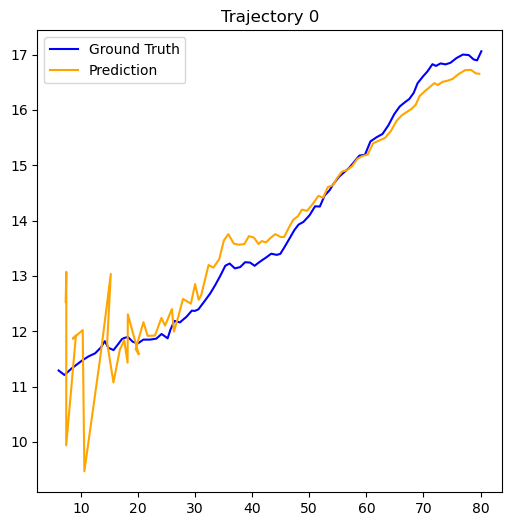

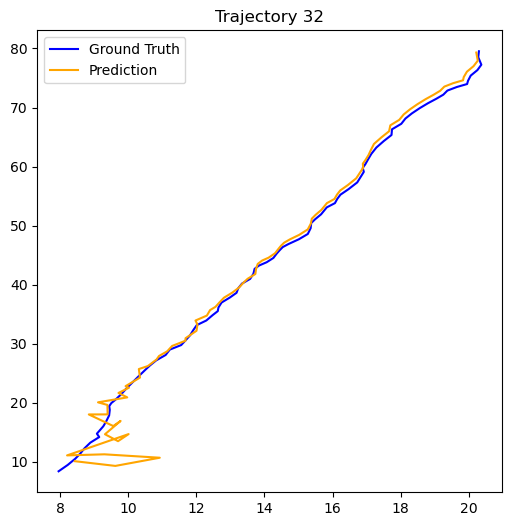

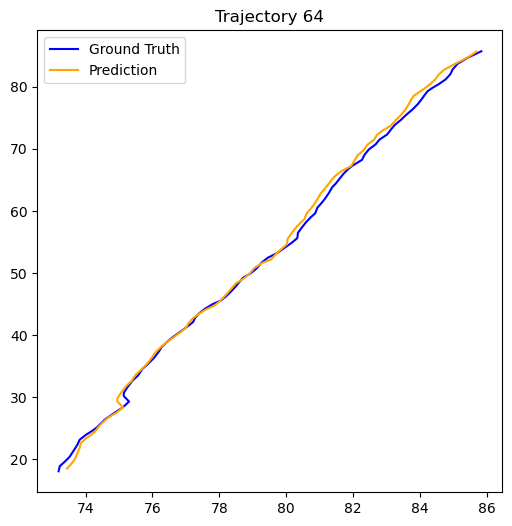

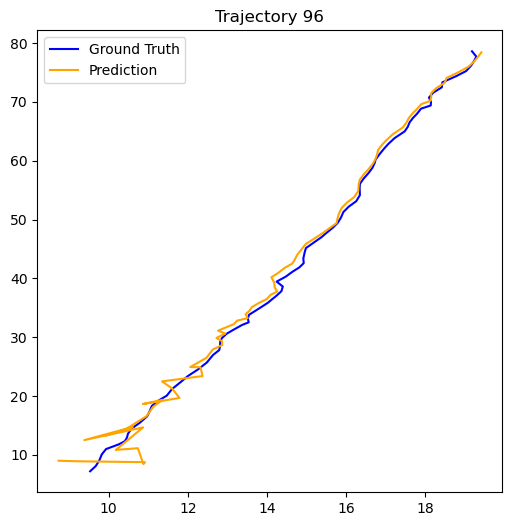

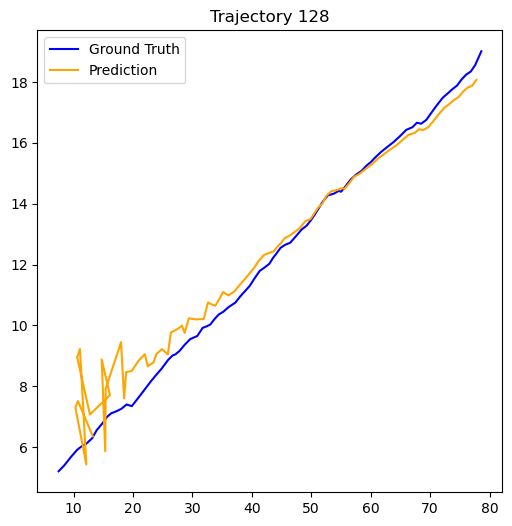

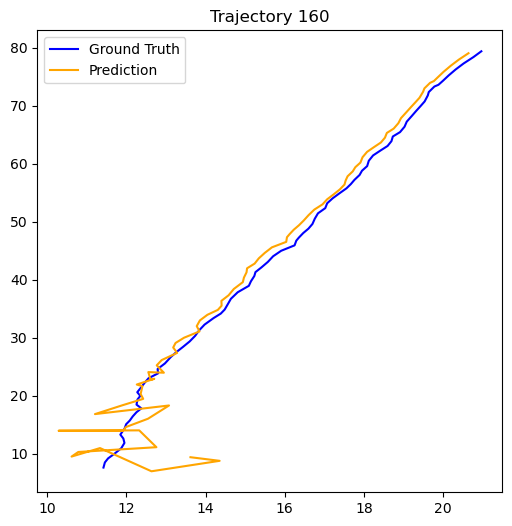

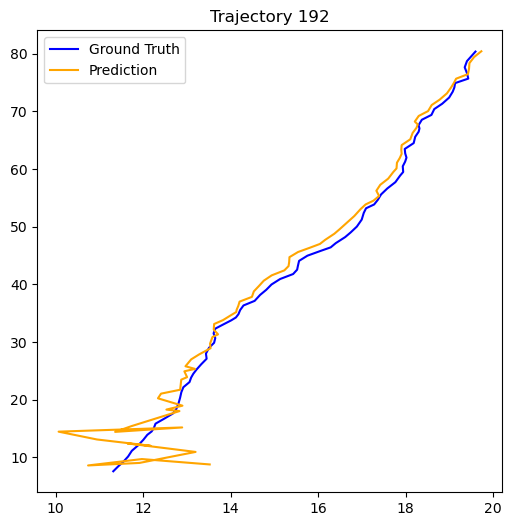

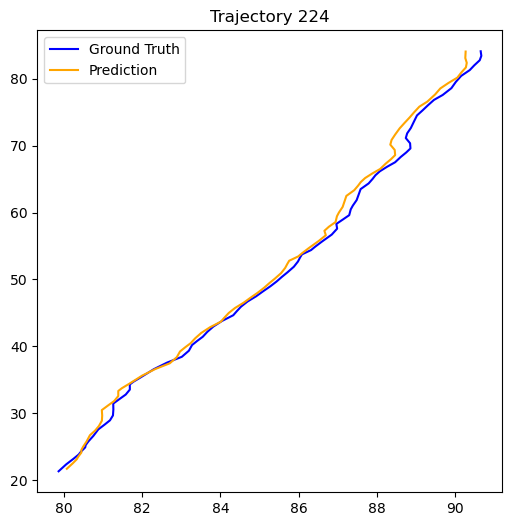

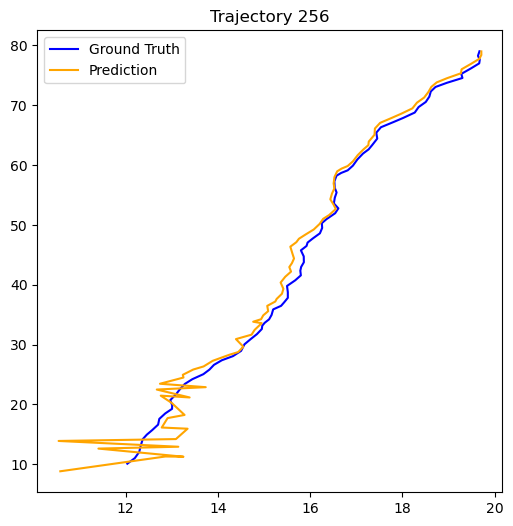

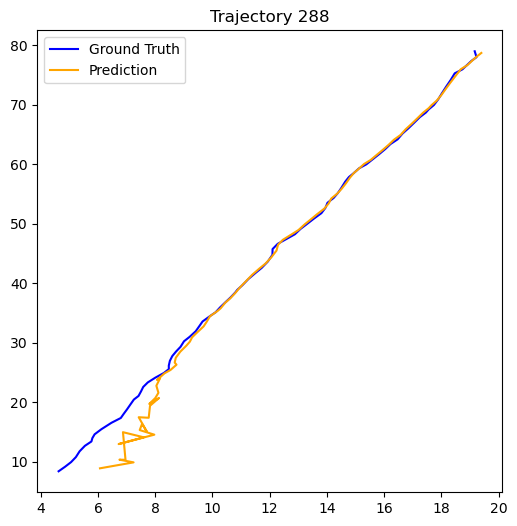

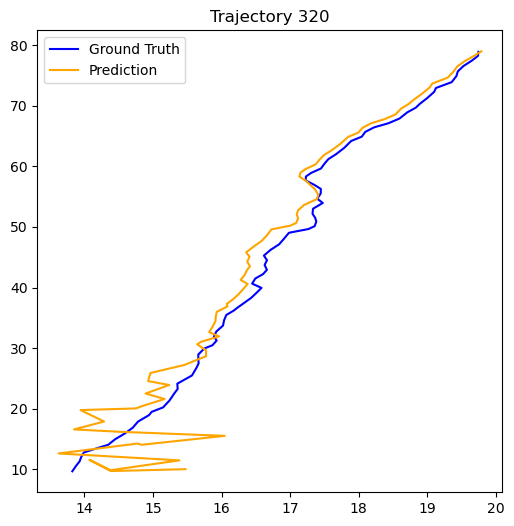

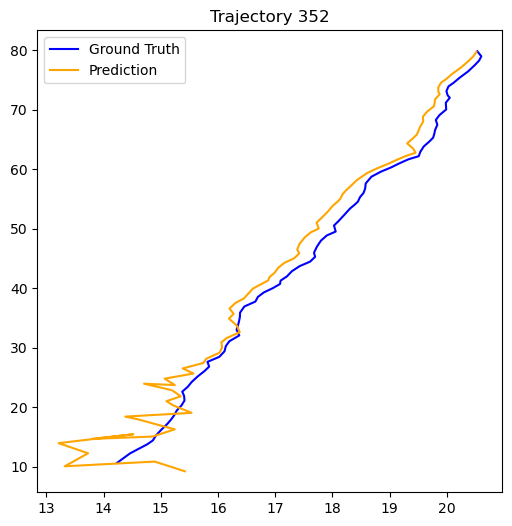

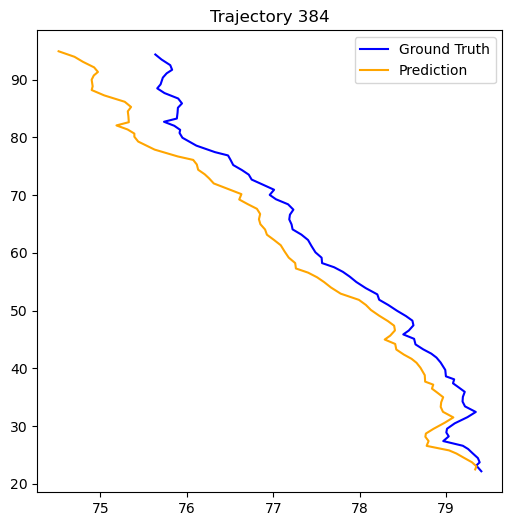

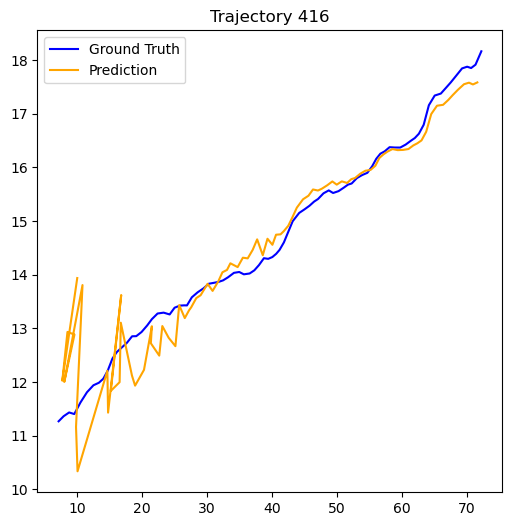

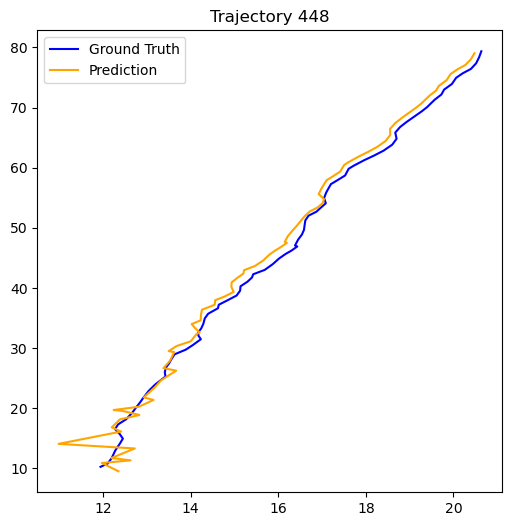

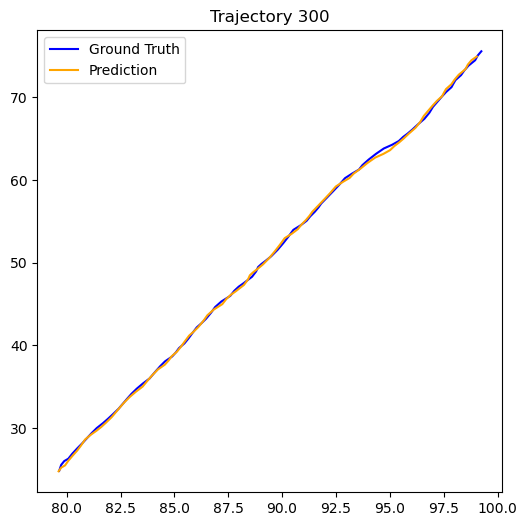

In [470]:
import matplotlib.pyplot as plt

vae.eval()

with torch.no_grad():
    for i, (inputs, targets) in enumerate(data_loader):
        inputs = inputs.to(torch.device('cuda' if torch.cuda.is_available() else 'cpu'))
        targets = targets.to(torch.device('cuda' if torch.cuda.is_available() else 'cpu'))

        # Predict next step
        recon_targets, _, _ = vae(inputs)

        # Visualize for the first few samples
        for j in range(1):  # Show 5 examples
            plt.figure(figsize=(6, 6))
            plt.plot(targets[j, :, 0].cpu().numpy(), targets[j, :, 1].cpu().numpy(), label="Ground Truth", c='blue')
            plt.plot(recon_targets[j, :, 0].cpu().numpy(), recon_targets[j, :, 1].cpu().numpy(), label="Prediction", c='orange')
            plt.legend()
            plt.title(f"Trajectory {i * len(inputs) + j}")
            plt.show()

### Cluster the latent layer

In [471]:
vae.eval()  # Set VAE to evaluation mode

latent_means = []

with torch.no_grad():
    for inputs, _ in data_loader:
        inputs = inputs.to(torch.device('cuda' if torch.cuda.is_available() else 'cpu'))  # Send to GPU if available
        mu, _ = vae.encode(inputs)  # Extract mu (shape: [batch_size, seq_len, latent_dim])
        
        # Aggregate means across sequence length to get a single latent point per trajectory
        mu_mean = mu.mean(dim=1)  # Shape: [batch_size, latent_dim]
        latent_means.append(mu_mean.cpu().numpy())

latent_means = np.vstack(latent_means)  # Final shape: (N, L)
print(f"Shape of projected data: {latent_means.shape}")

Shape of projected data: (500, 2)


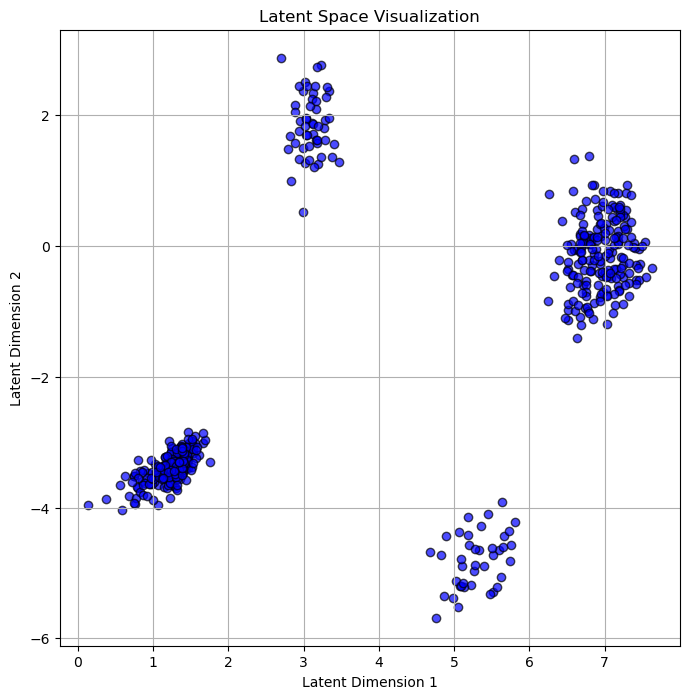

In [472]:
# Assuming latent_means is the output from your code
plt.figure(figsize=(8, 8))
plt.scatter(latent_means[:, 0], latent_means[:, 1], c='blue', alpha=0.7, edgecolors='k')
plt.title("Latent Space Visualization")
plt.xlabel("Latent Dimension 1")
plt.ylabel("Latent Dimension 2")
plt.grid()
plt.show()

In [519]:
from sklearn.cluster import KMeans

# Perform K-Means clustering
num_clusters = 4
kmeans = KMeans(n_clusters=num_clusters, random_state=42, n_init=10)
cluster_labels = kmeans.fit_predict(latent_means)

# Print unique cluster IDs
print(f"Cluster labels: {set(cluster_labels)}")

Cluster labels: {0, 1, 2, 3}


In [520]:
# Map trajectory IDs to cluster labels
trajectory_cluster_map = {idx: label for idx, label in enumerate(cluster_labels)}

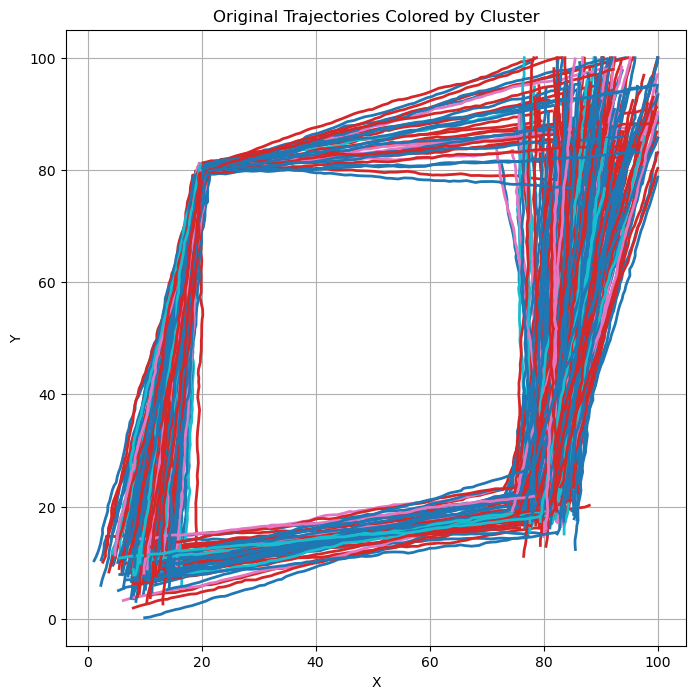

In [586]:
import numpy as np
import matplotlib.pyplot as plt

# Define colors for each cluster
colors = plt.colormaps['tab10'](np.linspace(0, 1, num_clusters))

plt.figure(figsize=(8, 8))

for traj_id, trajectory in simulation.trajectories.items():
    cluster_id = trajectory_cluster_map[traj_id]
    color = colors[cluster_id]
    
    # Convert trajectory to numpy array for plotting
    trajectory = np.array(trajectory)
    
    # Plot trajectory
    plt.plot(trajectory[:, 0], trajectory[:, 1], color=color, linewidth=2, label=f"Cluster {cluster_id}" if traj_id == 0 else "")
    
# Add visualization details
plt.title("Original Trajectories Colored by Cluster")
plt.xlabel("X")
plt.ylabel("Y")
plt.grid()
plt.show()